# Finite DMRG (second edition)

In [1]:
import numpy as np
import matplotlib.pyplot as plt

## Define Functions

### Initial Variables

In [2]:
def init_operators(s_x_operators,s_y_operators,s_z_operators,s_x_s_x_operators,s_z_s_z_operators,T_L_length,T_R_length,limit):
    for site_index in range(L):
        if site_index == 0:
            s_x_operators[site_index] = s_x
            s_y_operators[site_index] = s_y
            s_z_operators[site_index] = s_z
            s_x_s_x_operators[site_index] = np.dot(s_x,s_x)
            s_z_s_z_operators[site_index] = np.dot(s_z,s_z)
        elif site_index == L-1:
            s_x_operators[site_index] = s_x
            s_y_operators[site_index] = s_y
            s_z_operators[site_index] = s_z
        else:
            s_x_operators[site_index] = np.eye(2)
            s_y_operators[site_index] = np.eye(2)
            s_z_operators[site_index] = np.eye(2)
            if site_index < (L//2):
                s_x_s_x_operators[site_index] = s_x
                s_z_s_z_operators[site_index] = s_z
        if site_index < limit :
            T_R_length[site_index] = np.eye(2**limit)
            T_L_length[site_index] = np.eye(2**limit)

### Lanczos Method

In [3]:
def Lanczos_method(symmetric_matrix, first_q, desired_number) :
    Q = np.zeros((np.shape(symmetric_matrix[0])[0],desired_number+1))
    H = np.zeros((desired_number+1,desired_number))
    Q[:,1] = first_q.transpose() / np.linalg.norm(first_q)
    previous_b = 0
    step = 2
    i = 1
    
    for k in range(1,desired_number) :
        q_k = Q[:,k]
        v = np.dot(symmetric_matrix,q_k)
        temp = v
        a_k = np.dot(q_k.transpose().conjugate(),v)
        v = v - previous_b * Q[:,k-1] - a_k * q_k
        if(i % step == 0):
            for j in range(1,k-1):
                b = np.dot(Q[:,j].conjugate().transpose(),temp)
                v = v - b * Q[:,j]
        new_b = np.linalg.norm(v)
        Q[:,k+1] = v / new_b
        H[k-1,k-1] = a_k
        H[k-1,k] = new_b
        H[k,k-1] = new_b
        previous_b = new_b
        i += 1
    return H,Q

# Init

In [4]:
L = 60
limit = 4
H_C = 1
J = H_C/2
h = 1
sweep_step = 3
s_x = h/2*np.array([[0,1],
                [1,0]])
s_y = h/2*np.array([[0,-1j],
               [1j,0]])
s_z = h/2*np.array([[1,0],
                [0,-1]])

In [5]:
s_x_operators = [None] * L
s_y_operators = [None] * L
s_z_operators = [None] * L
s_x_s_x_operators = [None] * (L//2)
s_z_s_z_operators = [None] * (L//2)
H_L_length = [None] * (L)
H_R_length = [None] * (L)
T_L_length = [None] * (L)
T_R_length = [None] * (L)

## Infinite DMRG

In [6]:
init_operators(s_x_operators,s_y_operators,s_z_operators,s_x_s_x_operators,s_z_s_z_operators,T_L_length,T_R_length,limit)
H_L = np.zeros((2,2),dtype=np.complex128)
H_R = np.zeros((2,2),dtype=np.complex128)
H_L_length[0] = H_L
H_R_length[0] = H_R

for adding_site_index in range(1,L//2):
    
    # update Hamiltonian
    H_L = np.kron(H_L,np.eye(2))
    H_L += J*np.kron(s_z_operators[adding_site_index-1],s_z)
    H_L += H_C*np.kron(s_x_operators[adding_site_index],s_x)
    
    H_R = np.kron(np.eye(2),H_R)
    H_R += J*np.kron(s_z,s_z_operators[-adding_site_index])
    H_R += H_C*np.kron(s_x,s_x_operators[-adding_site_index-1])
    
    # update Sx,Sy,Sz
    for i in range(L//2):
        if (i == adding_site_index):
            s_x_operators[i] = np.kron(s_x_operators[i],s_x)
            s_y_operators[i] = np.kron(s_y_operators[i],s_y)
            s_z_operators[i] = np.kron(s_z_operators[i],s_z)
            # s_x_s_x_operators[i] = np.kron(s_x_s_x_operators[i],s_x)
            # s_z_s_z_operators[i] = np.kron(s_z_s_z_operators[i],s_z)
        else:
            s_x_operators[i] = np.kron(s_x_operators[i],np.eye(2))
            s_y_operators[i] = np.kron(s_y_operators[i],np.eye(2))
            s_z_operators[i] = np.kron(s_z_operators[i],np.eye(2))
            # s_x_s_x_operators[i] = np.kron(s_x_s_x_operators[i],np.eye(2))
            # s_z_s_z_operators[i] = np.kron(s_z_s_z_operators[i],np.eye(2))
    for j in range(L//2,L):
        if (j == L-adding_site_index-1):
            s_x_operators[j] = np.kron(s_x,s_x_operators[j])
            s_y_operators[j] = np.kron(s_y,s_y_operators[j])
            s_z_operators[j] = np.kron(s_z,s_z_operators[j])
        else:
            s_x_operators[j] = np.kron(np.eye(2),s_x_operators[j])
            s_y_operators[j] = np.kron(np.eye(2),s_y_operators[j])
            s_z_operators[j] = np.kron(np.eye(2),s_z_operators[j])
            
    # Truncation
    if (adding_site_index >= limit) :
        D_R = limit+1
        D_L = limit+1
        H = np.kron(H_L,np.eye(2**D_R)) + np.kron(np.eye(2**D_L),H_R)
        H += J*np.dot(np.kron(s_z_operators[adding_site_index],np.eye(2**D_R)),np.kron(np.eye(2**D_L),s_z_operators[L-adding_site_index-1]))
        
        eigenvalues, eigenvectors = np.linalg.eigh(H)
        ground_state = eigenvectors[:,0]
        ground_state_tiled = np.reshape(ground_state, (2**D_R,2**D_L))
        rho_L = ground_state_tiled @ ground_state_tiled.conj().T
        rho_R = ground_state_tiled.T @ ground_state_tiled.conj()
        
        L_eigenvalues, L_eigenvectors = np.linalg.eigh(rho_L)
        R_eigenvalues, R_eigenvectors = np.linalg.eigh(rho_R)
        
        T_L = L_eigenvectors[:,(-2**limit):]
        U_L = T_L[:, ::-1]
        
        T_R = R_eigenvectors[:,(-2**limit):]
        U_R = T_R[:, ::-1]
        
        H_L = U_L.conj().T @ H_L @ U_L
        H_R = U_R.conj().T @ H_R @ U_R
        
        T_L_length[adding_site_index] = U_L
        T_R_length[adding_site_index] = U_R
        
        for k in range(L//2):
            s_x_operators[k] = U_L.conj().T @ s_x_operators[k] @ U_L
            s_y_operators[k] = U_L.conj().T @ s_y_operators[k] @ U_L
            s_z_operators[k] = U_L.conj().T @ s_z_operators[k] @ U_L
            # s_x_s_x_operators[k] = U_L.conj().T @ s_x_s_x_operators[k] @ U_L
            # s_z_s_z_operators[k] = U_L.conj().T @ s_z_s_z_operators[k] @ U_L
        for m in range(L//2,L):
            s_x_operators[m] = U_R.conj().T @ s_x_operators[m] @ U_R
            s_y_operators[m] = U_R.conj().T @ s_y_operators[m] @ U_R
            s_z_operators[m] = U_R.conj().T @ s_z_operators[m] @ U_R
            
    
    H_L_length[adding_site_index] = H_L
    H_R_length[adding_site_index] = H_R

In [7]:
H_infinite = np.kron(H_L,np.eye(2**D_R))+np.kron(np.eye(2**D_L),H_R)
H_infinite += J*np.dot(np.kron(s_z_operators[L//2-1],np.eye(2**D_R)),np.kron(np.eye(2**D_L),s_z_operators[L//2]))
Heig, Hiegv = np.linalg.eigh(H_infinite)
print('The Ground State Energy with Infinite DMRG : ')
print(Heig[0])

The Ground State Energy with Infinite DMRG : 
-29.4785169073468


## Finite DMRG

### Before Sweep (30,30) -> (56,4)

In [8]:
for i in range(L//2,L-limit-1):
    H_L = H_L_length[i-1]
    H_R = H_R_length[-i-2]
    
    H_L = np.kron(H_L,np.eye(2))
    H_L += J*np.kron(s_z_operators[i-1],s_z)
    H_L += H_C*np.kron(np.eye(2**limit),s_x)
    
    # transform to original (not truncated)
    H_R = T_R_length[-i-2] @ H_R @ T_R_length[-i-2] .T
    temp_s_z_1 = np.kron(np.eye(2**limit),s_z)
    temp_s_z_2 = T_R_length[-i-2] @ s_z_operators[-i-2] @ T_R_length[-i-2].T
    
    H = np.kron(H_L,np.eye(2**D_R)) + np.kron(np.eye(2**D_L),H_R)
    H += J*np.dot(np.kron(temp_s_z_1,np.eye(2**D_R)),np.kron(np.eye(2**D_L),temp_s_z_2))
    
    eigenvalues, eigenvectors = np.linalg.eigh(H)
    ground_state = eigenvectors[:,0]
    ground_state_tiled = np.reshape(ground_state, (2**D_R,2**D_L))
    rho_L = ground_state_tiled @ ground_state_tiled.conj().T

    L_eigenvalues, L_eigenvectors = np.linalg.eigh(rho_L)
    T_L = L_eigenvectors[:,(-2**limit):]
    U_L = T_L[:, ::-1]
    
    T_L_length[i] = U_L
    H_L_length[i] = U_L.conj().T @ H_L @ U_L
    
    # update operators
    for j in range(i+1):
        if (j==i):
            s_x_operators[j] = np.kron(np.eye(2**limit),s_x)
            s_y_operators[j] = np.kron(np.eye(2**limit),s_y)
            s_z_operators[j] = np.kron(np.eye(2**limit),s_z)
        else:
            s_x_operators[j] = np.kron(s_x_operators[j],np.eye(2))
            s_y_operators[j] = np.kron(s_y_operators[j],np.eye(2))
            s_z_operators[j] = np.kron(s_z_operators[j],np.eye(2))
    # truncation 
    for k in range(i+1):
        s_x_operators[k] = U_L.conj().T @ s_x_operators[k] @ U_L
        s_y_operators[k] = U_L.conj().T @ s_y_operators[k] @ U_L
        s_z_operators[k] = U_L.conj().T @ s_z_operators[k] @ U_L
        

In [9]:
H_b_sweep = np.kron(H_L_length[L-limit-2],np.eye(2**D_R)) + np.kron(np.eye(2**D_L),H_R_length[limit])
H_b_sweep += J*np.dot(np.kron(s_z_operators[L//2-1],np.eye(2**D_R)),np.kron(np.eye(2**D_L),s_z_operators[L//2]))
Heig_b_sweep, Hiegv_b_sweep = np.linalg.eigh(H_b_sweep)
print('The Ground State Energy after first iteration and before sweep: ')
print(Heig_b_sweep[0])

The Ground State Energy after first iteration and before sweep: 
-29.417457469302583


## Before sweep back (56,4) -> (4,56)

In [10]:
s_z_operators[L-limit] = np.kron(s_z,np.eye(2**(limit-1)))
s_x_operators[L-limit] = np.kron(s_x,np.eye(2**(limit-1)))
s_y_operators[L-limit] = np.kron(s_y,np.eye(2**(limit-1)))
for i in range(L-limit-1,limit+1,-1):
    H_R = H_R_length[L-i-2]
    H_L = H_L_length[i-2]
    
    H_R = np.kron(np.eye(2),H_R)
    H_R += J*np.kron(s_z,s_z_operators[i+1])
    H_R += H_C*np.kron(s_x,np.eye(2**limit))
    
    
    H_L = T_L_length[i-2] @ H_L @ T_L_length[i-2].T
    
    temp_s_z_1 = T_L_length[i-1] @ s_z_operators[i-1] @ T_L_length[i-1].T
    temp_s_z_2 = np.kron(s_z,np.eye(2**limit))
    
    H = np.kron(H_L,np.eye(2**D_R)) + np.kron(np.eye(2**D_L),H_R)
    H += J*np.dot(np.kron(temp_s_z_1,np.eye(2**D_R)),np.kron(np.eye(2**D_L),temp_s_z_2))
    
    eigenvalues, eigenvectors = np.linalg.eigh(H)
    ground_state = eigenvectors[:,0]
    ground_state_tiled = np.reshape(ground_state, (2**D_L,2**D_R))
    rho_R = ground_state_tiled.T @ ground_state_tiled.conj()

    R_eigenvalues, R_eigenvectors = np.linalg.eigh(rho_R)
    T_R = R_eigenvectors[:,(-2**limit):]
    U_R = T_R[:, ::-1]
    
    T_R_length[L-i] = U_R
    H_R_length[L-i] = U_R.conj().T @ H_R @ U_R

    # update operators
    for k in range(i,L):
        if(k==i):
            s_x_operators[k] = np.kron(s_x,np.eye(2**limit))
            s_y_operators[k] = np.kron(s_y,np.eye(2**limit))
            s_z_operators[k] = np.kron(s_z,np.eye(2**limit))
        else:
            s_x_operators[k] = np.kron(np.eye(2),s_x_operators[k])
            s_y_operators[k] = np.kron(np.eye(2),s_y_operators[k])
            s_z_operators[k] = np.kron(np.eye(2),s_z_operators[k])
    # truncation
    for j in range(i,L):
        s_x_operators[j] = U_R.conj().T @ s_x_operators[j] @ U_R
        s_y_operators[j] = U_R.conj().T @ s_y_operators[j] @ U_R
        s_z_operators[j] = U_R.conj().T @ s_z_operators[j] @ U_R

In [11]:
H_b_sweep = np.kron(H_L_length[L-limit-2],np.eye(2**D_R)) + np.kron(np.eye(2**D_L),H_R_length[limit])
H_b_sweep += J*np.dot(np.kron(s_z_operators[L//2-1],np.eye(2**D_R)),np.kron(np.eye(2**D_L),s_z_operators[L//2]))
Heig_b_sweep, Hiegv_b_sweep = np.linalg.eigh(H_b_sweep)
print('The Ground State Energy after second iteration and before sweep: ')
print(Heig_b_sweep[0])

The Ground State Energy after second iteration and before sweep: 
-29.417457470171406


## Sweep

In [12]:
def plot_correlations(s_x_operators,s_y_operators,s_z_operators,gs,step):
    s_x_averages = np.zeros(L)
    s_y_averages = np.zeros(L)
    s_z_averages = np.zeros(L)
    for i in range(L):
        s_x_averages[i] = (gs.conj().T @ s_x_operators[i] @ gs).real
        s_y_averages[i] = (gs.conj().T @ s_y_operators[i] @ gs).real
        s_z_averages[i] = (gs.conj().T @ s_z_operators[i] @ gs).real
        
    plt.figure(figsize=(10, 4))
    plt.plot(np.arange(0,L,1), s_x_averages, 'bo-')
    plt.xlabel('Site Index')
    plt.ylabel('$<S_x>$')
    plt.title('$<S_x>$ by Site Number in step ' + str(step+1))
    plt.grid(True)
    plt.show()
        
    plt.figure(figsize=(10, 4))
    plt.plot(np.arange(0,L,1), s_y_averages, 'ro-')
    plt.xlabel('Site Index')
    plt.ylabel('$<S_y>$')
    plt.title('$<S_y>$ by Site Number in step ' + str(step+1))
    plt.grid(True)
    plt.show()
    
    plt.figure(figsize=(10, 4))
    plt.plot(np.arange(0,L,1), s_z_averages, 'go-')
    plt.xlabel('Site Index')
    plt.ylabel('$<S_Z>$')
    plt.title('$<S_z>$ by Site Number in step ' + str(step+1))
    plt.grid(True)
    plt.show()

The Ground State Energy after 0 sweep: 
-29.351936371316445


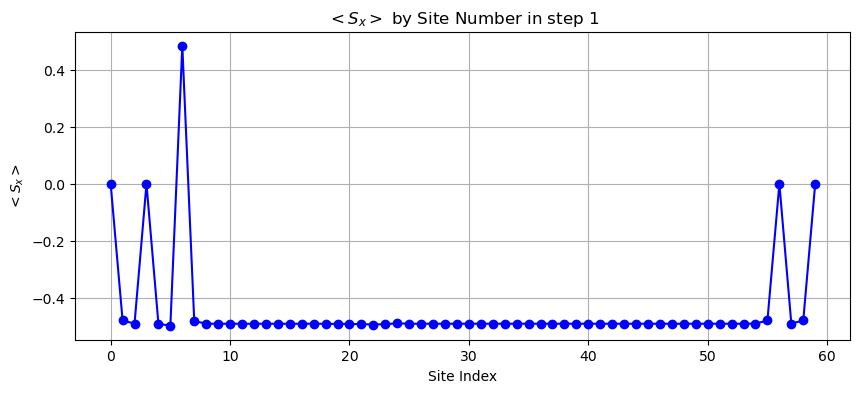

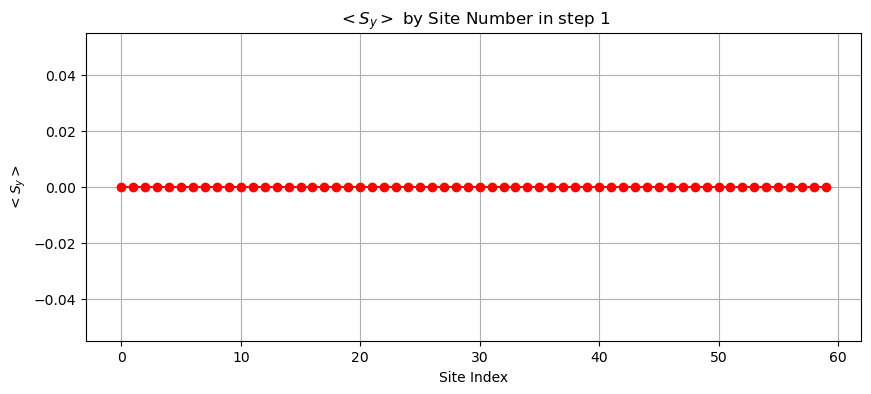

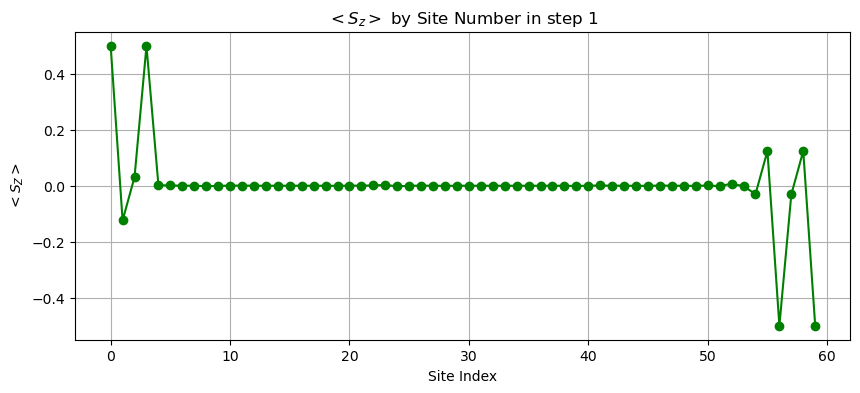

The Ground State Energy after 1 sweep: 
-29.325255451372605


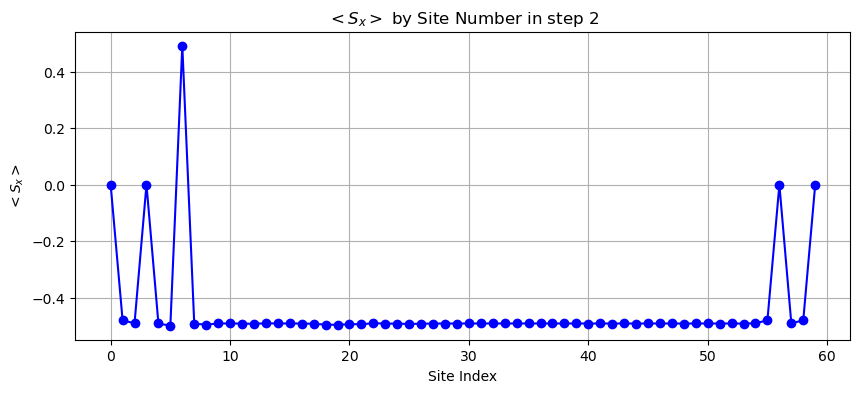

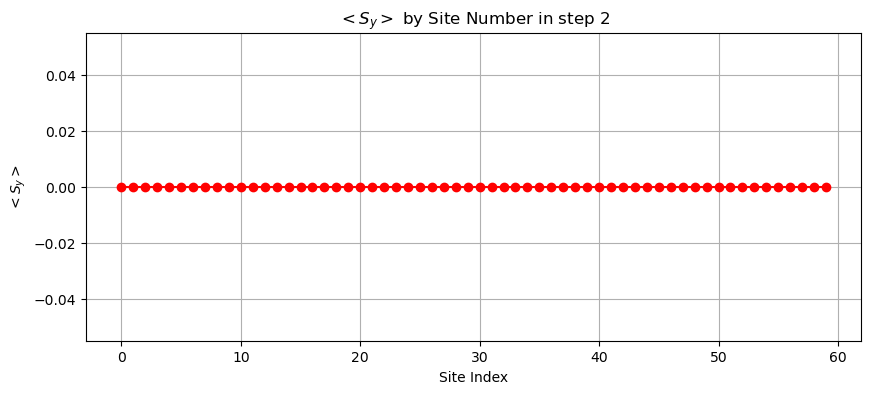

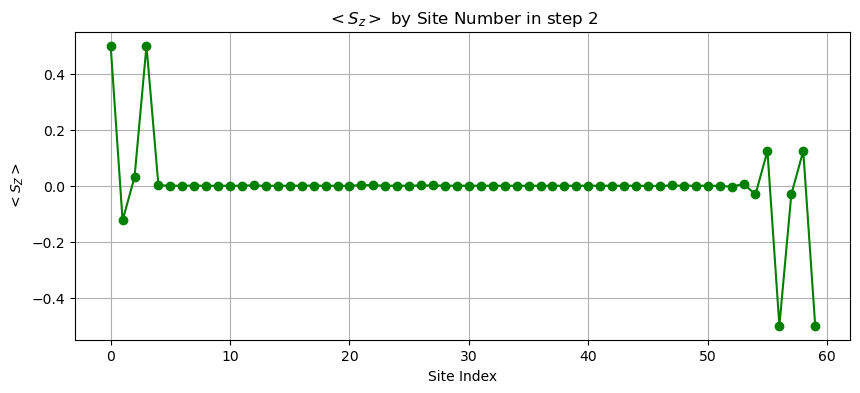

The Ground State Energy after 2 sweep: 
-29.312613382436535


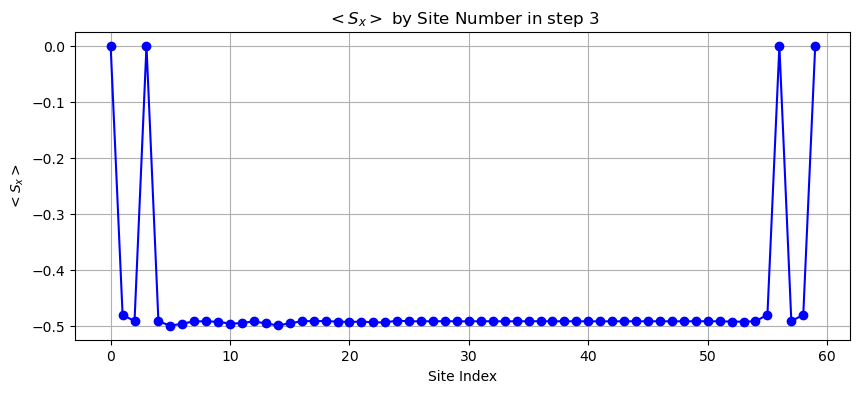

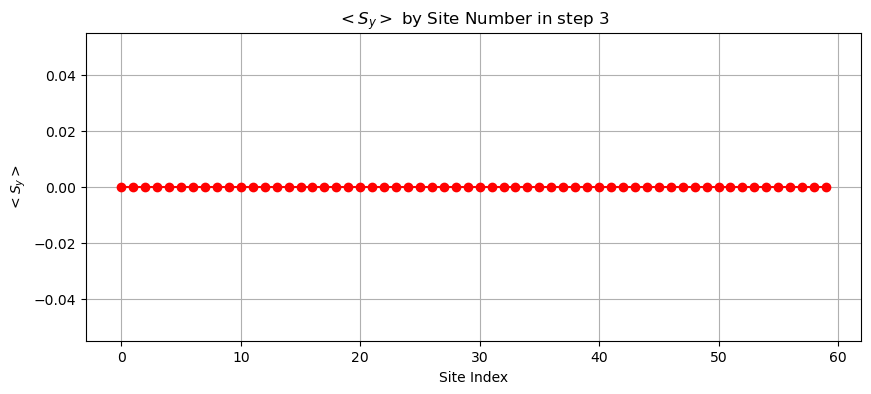

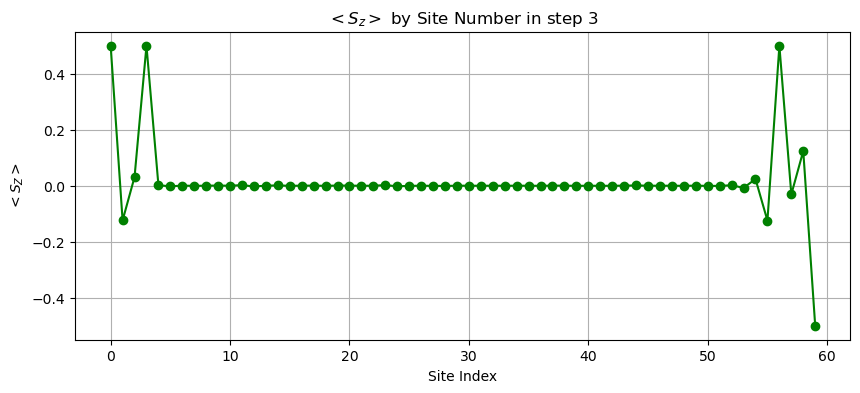

In [13]:
for step in range(sweep_step):
    
    # right to left sweep
    
    s_z_operators[limit-1] = np.kron(np.eye(2**(limit-1)),s_z)
    s_x_operators[limit-1] = np.kron(np.eye(2**(limit-1)),s_x)
    s_y_operators[limit-1] = np.kron(np.eye(2**(limit-1)),s_y)
    for i in range(limit+1,L-limit-1):
        H_L = H_L_length[i-1]
        H_R = H_R_length[-i-2]

        H_L = np.kron(H_L,np.eye(2))
        H_L += J*np.kron(s_z_operators[i-1],s_z)
        H_L += H_C*np.kron(np.eye(2**limit),s_x)

        # transform to original (not truncated)
        H_R = T_R_length[-i-2] @ H_R @ T_R_length[-i-2] .T
        temp_s_z_1 = np.kron(np.eye(2**limit),s_z)
        temp_s_z_2 = T_R_length[-i-2] @ s_z_operators[-i-2] @ T_R_length[-i-2].T

        H = np.kron(H_L,np.eye(2**D_R)) + np.kron(np.eye(2**D_L),H_R)
        H += J*np.dot(np.kron(temp_s_z_1,np.eye(2**D_R)),np.kron(np.eye(2**D_L),temp_s_z_2))

        eigenvalues, eigenvectors = np.linalg.eigh(H)
        ground_state = eigenvectors[:,0]
        ground_state_tiled = np.reshape(ground_state, (2**D_R,2**D_L))
        rho_L = ground_state_tiled @ ground_state_tiled.conj().T

        L_eigenvalues, L_eigenvectors = np.linalg.eigh(rho_L)
        T_L = L_eigenvectors[:,(-2**limit):]
        U_L = T_L[:, ::-1]

        T_L_length[i] = U_L
        H_L_length[i] = U_L.conj().T @ H_L @ U_L
        
        if (i == L//2):
            psi_lanczos = ground_state

        # update operators
        for j in range(i+1):
            if (j==i):
                s_x_operators[j] = np.kron(np.eye(2**limit),s_x)
                s_y_operators[j] = np.kron(np.eye(2**limit),s_y)
                s_z_operators[j] = np.kron(np.eye(2**limit),s_z)
            else:
                s_x_operators[j] = np.kron(s_x_operators[j],np.eye(2))
                s_y_operators[j] = np.kron(s_y_operators[j],np.eye(2))
                s_z_operators[j] = np.kron(s_z_operators[j],np.eye(2))
        # truncation 
        for k in range(i+1):
            s_x_operators[k] = U_L.conj().T @ s_x_operators[k] @ U_L
            s_y_operators[k] = U_L.conj().T @ s_y_operators[k] @ U_L
            s_z_operators[k] = U_L.conj().T @ s_z_operators[k] @ U_L
        
    # left to right sweep
    
    s_z_operators[L-limit] = np.kron(np.eye(2**(limit-1)),s_z)
    s_x_operators[L-limit] = np.kron(np.eye(2**(limit-1)),s_x)
    s_y_operators[L-limit] = np.kron(np.eye(2**(limit-1)),s_y)
    for i in range(L-limit-1,limit+1,-1):
        H_R = H_R_length[L-i-2]
        H_L = H_L_length[i-2]

        H_R = np.kron(np.eye(2),H_R)
        H_R += J*np.kron(s_z,s_z_operators[i+1])
        H_R += H_C*np.kron(s_x,np.eye(2**limit))


        H_L = T_L_length[i-2] @ H_L @ T_L_length[i-2].T

        temp_s_z_1 = T_L_length[i-1] @ s_z_operators[i-1] @ T_L_length[i-1].T
        temp_s_z_2 = np.kron(s_z,np.eye(2**limit))

        H = np.kron(H_L,np.eye(2**D_R)) + np.kron(np.eye(2**D_L),H_R)
        H += J*np.dot(np.kron(temp_s_z_1,np.eye(2**D_R)),np.kron(np.eye(2**D_L),temp_s_z_2))

        eigenvalues, eigenvectors = np.linalg.eigh(H)
        ground_state = eigenvectors[:,0]
        ground_state_tiled = np.reshape(ground_state, (2**D_L,2**D_R))
        rho_R = ground_state_tiled.T @ ground_state_tiled.conj()

        R_eigenvalues, R_eigenvectors = np.linalg.eigh(rho_R)
        T_R = R_eigenvectors[:,(-2**limit):]
        U_R = T_R[:, ::-1]

        T_R_length[L-i] = U_R
        H_R_length[L-i] = U_R.conj().T @ H_R @ U_R

        # update operators
        for k in range(i,L):
            if(k==i):
                s_x_operators[k] = np.kron(s_x,np.eye(2**limit))
                s_y_operators[k] = np.kron(s_y,np.eye(2**limit))
                s_z_operators[k] = np.kron(s_z,np.eye(2**limit))
            else:
                s_x_operators[k] = np.kron(np.eye(2),s_x_operators[k])
                s_y_operators[k] = np.kron(np.eye(2),s_y_operators[k])
                s_z_operators[k] = np.kron(np.eye(2),s_z_operators[k])
        # truncation
        for j in range(i,L):
            s_x_operators[j] = U_R.conj().T @ s_x_operators[j] @ U_R
            s_y_operators[j] = U_R.conj().T @ s_y_operators[j] @ U_R
            s_z_operators[j] = U_R.conj().T @ s_z_operators[j] @ U_R
    # plot result
    H_temp = np.kron(H_L_length[L-limit-2],np.eye(2**D_R)) + np.kron(np.eye(2**D_L),H_R_length[limit])
    H_temp += J*np.dot(np.kron(s_z_operators[L//2-1],np.eye(2**D_R)),np.kron(np.eye(2**D_L),s_z_operators[L//2]))
    Heig_temp, Hiegv_temp = np.linalg.eigh(H_temp)
    print('The Ground State Energy after '+str(step)+' sweep: ')
    print(Heig_temp[0])
    U = Hiegv_temp[:,:2**limit]
    H_temp = U.conj().T @ H_temp @ U
    Heig_temp, Hiegv_temp = np.linalg.eigh(H_temp)
    plot_correlations(s_x_operators,s_y_operators,s_z_operators,Hiegv_temp[:,0],step)


# Lanczos Method

In [14]:
psi_lanczos = np.reshape(psi_lanczos,(2**D_R,2**D_L))
psi_lanczos = T_L_length[L//2].T @ psi_lanczos
psi_lanczos = np.reshape(psi_lanczos,(2**limit,2**limit,2))
psi_lanczos = np.transpose(psi_lanczos, (0, 2, 1))
psi_lanczos = np.reshape(psi_lanczos,(2**D_R,2**limit))
psi_lanczos = psi_lanczos @ T_R_length[L//2].T
H_temp = np.kron(H_L_length[L-limit-2],np.eye(2**(D_R+1))) + np.kron(np.eye(2**(D_L+1)),H_R_length[limit])
H_temp += J*np.dot(np.kron(s_z_operators[L//2-1],np.eye(2**(D_R+1))),np.kron(np.eye(2**(D_L+1)),s_z_operators[L//2]))
feig, feigv = np.linalg.eigh(H_temp)
first_q = np.reshape(psi_lanczos,(2**10,1))
modified_H,modified_Q = Lanczos_method(H_temp, first_q, 4)
modified_Q = modified_Q[:,1:]
modified_Tk = np.dot(np.dot(modified_Q.transpose(),H_temp),modified_Q)
modified_lanczos_eigen_values, modified_lanczos_eigen_vectors = np.linalg.eigh(modified_Tk)
print('The Ground State Energy With Lanczos Method ')
print(modified_lanczos_eigen_values[0])
modified_lanczos_eigen_vectors_final = np.dot(modified_Q,modified_lanczos_eigen_vectors)
np.dot(modified_lanczos_eigen_vectors_final[:,0],feigv[:,0])

The Ground State Energy With Lanczos Method 
-29.311821894762456


C:\Users\Amir\AppData\Local\Temp\ipykernel_16772\989659589.py:4: ComplexWarning: Casting complex values to real discards the imaginary part
  Q[:,1] = first_q.transpose() / np.linalg.norm(first_q)
C:\Users\Amir\AppData\Local\Temp\ipykernel_16772\989659589.py:20: ComplexWarning: Casting complex values to real discards the imaginary part
  Q[:,k+1] = v / new_b
C:\Users\Amir\AppData\Local\Temp\ipykernel_16772\989659589.py:21: ComplexWarning: Casting complex values to real discards the imaginary part
  H[k-1,k-1] = a_k


(-0.7010088532413472+0j)